In [1]:
import pandas as pd
import yaml
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
)
import numpy as np
from modeling import create_model, create_reg_model, update_config

In [2]:
pbp = pd.read_parquet("data/pbp.parquet")
pbp["year"] = pbp["game_id"].apply(lambda x: int(x.split("_")[0]))
small = pbp.loc[pbp.year > 2021].dropna(how="all", axis=1)
print(pbp.columns)

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'defense_players', 'n_offense', 'n_defense', 'ngs_air_yards',
       'time_to_throw', 'was_pressure', 'route', 'defense_man_zone_type',
       'defense_coverage_type', 'year'],
      dtype='object', length=393)


In [3]:
desc_cols = [
    "play_id",
    "game_id",
    "home_team",
    "away_team",
    "game_half",
    "posteam",
    "side_of_field",
    "desc",
]


In [4]:
play_type_mapping = {
    "field_goal": 0,
    "no_play": 1,
    "pass": 2,
    "punt": 3,
    "qb_kneel": 4,
    "qb_spike": 5,
    "run": 6,
    np.nan: 7,
}

In [5]:
game_context_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    # "yards_gained",
    "posteam_score",
    # "total_away_score",
    "score_differential",
    "quarter_seconds_remaining",
    "half_seconds_remaining",
    "game_seconds_remaining",
    "wind",
    "temp",
    "spread_line",
    "total_line",
]

pbp["play_type_enc"] = pbp["play_type"].map(play_type_mapping)
y_col = "play_type_enc"
data = pbp.loc[
    (~pbp.down.isna()) & (~pbp.rush_attempt.isna()) & ~(pbp.play_type.isna())
][game_context_cols + [y_col]]

In [6]:
team_receiver_stats = pd.read_csv("data/team_receiver_stats.csv", index_col=0)
receiver_cols = [x for x in team_receiver_stats.columns if "ception" in x] + [
    x for x in team_receiver_stats.columns if "arget" in x
] + [x for x in team_receiver_stats.columns if "ppr" in x] + [
    x for x in team_receiver_stats.columns if "pct" in x]


In [52]:
team_rusher_cols = ['carries_roll_QB_0',
 'carries_roll_QB_1',
 'carries_roll_RB_0',
 'carries_roll_RB_1',
 'carries_roll_RB_2',
 'carries_roll_TE_0',
 'carries_roll_WR_0',
 'fantasy_points_ppr_roll_QB_0',
 'fantasy_points_ppr_roll_QB_1',
 'fantasy_points_ppr_roll_RB_0',
 'fantasy_points_ppr_roll_RB_1',
 'fantasy_points_ppr_roll_RB_2',
 'fantasy_points_ppr_roll_TE_0',
 'fantasy_points_ppr_roll_WR_0',
 'offense_pct_roll_QB_0',
 'offense_pct_roll_QB_1',
 'offense_pct_roll_RB_0',
 'offense_pct_roll_RB_1',
 'offense_pct_roll_RB_2',
 'offense_pct_roll_TE_0',
 'offense_pct_roll_WR_0',
 'rushing_first_downs_roll_QB_0',
 'rushing_first_downs_roll_QB_1',
 'rushing_first_downs_roll_RB_0',
 'rushing_first_downs_roll_RB_1',
 'rushing_first_downs_roll_RB_2',
 'rushing_first_downs_roll_TE_0',
 'rushing_first_downs_roll_WR_0',
 'rushing_tds_roll_QB_0',
 'rushing_tds_roll_QB_1',
 'rushing_tds_roll_RB_0',
 'rushing_tds_roll_RB_1',
 'rushing_tds_roll_RB_2',
 'rushing_tds_roll_TE_0',
 'rushing_tds_roll_WR_0',
 'rushing_yards_roll_QB_0',
 'rushing_yards_roll_QB_1',
 'rushing_yards_roll_RB_0',
 'rushing_yards_roll_RB_1',
 'rushing_yards_roll_RB_2',
 'rushing_yards_roll_TE_0',
 'rushing_yards_roll_WR_0',
 'last_rusher_drive',
 'last_rusher_team']

In [ ]:
def get_rusher_number(row):
    """0-2 is RB, 3-7 is WR, 8-10 is TE"""
    for num, col_name in enumerate(
        [
            "gsis_id_RB_0",
            "gsis_id_RB_1",
            "gsis_id_RB_2",
            "gsis_id_QB_0",
            "gsis_id_QB_1",
            "gsis_id_TE_0",
            "gsis_id_WR_0",
        ]
    ):
        if row[col_name] == row["rusher_player_id"]:
            return num
    return None

In [36]:
'''def get_rusher_number(row):
    for i in range(3):
        if row[f"gsis_id_RB_{i}"] == row["rusher_id"]:
            return i
    return None'''

'def get_rusher_number(row):\n    for i in range(3):\n        if row[f"gsis_id_RB_{i}"] == row["rusher_id"]:\n            return i\n    return None'

In [40]:
team_rb_stats = pd.read_csv("data/team_rushers.csv", index_col=0)
comb = pbp.merge(
    team_rb_stats,
    left_on=["posteam", "season", "week"],
    right_on=["team_name", "season", "week"],
)

comb["rusher_depth_num"] = comb.apply(get_rusher_number, axis=1)
rushes = comb.loc[(~comb.rusher_depth_num.isna()) & (~comb.yards_gained.isna())].copy(
    deep=True
)
rushes["last_rusher_drive"] = (
    rushes.groupby(["game_id", "drive", "posteam"])["rusher_depth_num"]
    .shift()
    .fillna(-1)
)
rushes["last_rusher_team"] = (
    rushes.groupby(["game_id", "posteam"])["rusher_depth_num"].shift().fillna(-1)
)
rushes[(game_context_cols + team_rb_cols)]

,yardline_100,down,goal_to_go,ydstogo,posteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,...,rushing_first_downs_roll_RB_2,rushing_first_downs_roll_RB_0,fantasy_points_roll_RB_1,fantasy_points_roll_RB_2,fantasy_points_roll_RB_0,fantasy_points_ppr_roll_RB_1,fantasy_points_ppr_roll_RB_2,fantasy_points_ppr_roll_RB_0,last_rusher_drive,last_rusher_team
2,78.0,2.0,0,10.0,0.0,0.0,864.0,1764.0,3564.0,NaN,...,3.000000,3.000000,NaN,6.500000,11.400000,NaN,9.500000,15.40000,-1.0,-1.0
5,38.0,1.0,0,10.0,0.0,0.0,772.0,1672.0,3472.0,NaN,...,3.000000,3.000000,NaN,6.500000,11.400000,NaN,9.500000,15.40000,0.0,0.0
7,24.0,1.0,0,10.0,0.0,0.0,701.0,1601.0,3401.0,NaN,...,3.000000,3.000000,NaN,6.500000,11.400000,NaN,9.500000,15.40000,0.0,0.0
8,22.0,2.0,0,8.0,0.0,0.0,663.0,1563.0,3363.0,NaN,...,3.000000,3.000000,NaN,6.500000,11.400000,NaN,9.500000,15.40000,0.0,0.0
10,19.0,1.0,0,10.0,0.0,0.0,626.0,1526.0,3326.0,NaN,...,NaN,6.000000,0.200000,NaN,8.700000,0.200000,NaN,12.70000,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675873,10.0,2.0,0,9.0,27.0,-3.0,132.0,132.0,132.0,NaN,...,0.156107,3.136747,1.625107,1.003023,17.239344,1.729408,1.509562,20.11984,-1.0,0.0
675876,80.0,1.0,0,10.0,30.0,3.0,113.0,113.0,113.0,NaN,...,0.979235,3.459568,1.318234,3.223182,11.380990,1.917779,5.512374,14.28707,-1.0,0.0
675877,73.0,2.0,0,3.0,30.0,3.0,107.0,107.0,107.0,NaN,...,0.979235,3.459568,1.318234,3.223182,11.380990,1.917779,5.512374,14.28707,0.0,0.0
675884,29.0,1.0,0,10.0,32.0,5.0,72.0,72.0,72.0,NaN,...,0.979235,3.459568,1.318234,3.223182,11.380990,1.917779,5.512374,14.28707,-1.0,0.0


In [45]:
comb.loc[comb.rusher_player_name=='J.Hurts'][['home_team','season','week','rusher_player_id','rusher_depth_num', 'gsis_id_QB_0',
                                              'gsis_id_QB_1','desc']]

,home_team,season,week,rusher_player_id,rusher_depth_num,gsis_id_QB_0,gsis_id_QB_1,desc
462838,PHI,2020,3,00-0036389,NaN,00-0032950,00-0032792,(11:46) (Shotgun) Direct snap to 2-J.Hurts. 2-...
462875,PHI,2020,3,00-0036389,NaN,00-0032950,00-0032792,(11:43) (Shotgun) 2-J.Hurts to PHI 44 for -3 y...
467357,SF,2020,4,00-0036389,4.0,00-0032950,00-0036389,(1:24) #2 J.Hurts in at QB. (Shotgun) 2-J.Hurt...
467409,SF,2020,4,00-0036389,4.0,00-0032950,00-0036389,(9:58) 2-J.Hurts right end ran ob at SF 38 for...
467415,SF,2020,4,00-0036389,4.0,00-0032950,00-0036389,(6:39) (Shotgun) 2-J.Hurts FUMBLES (Aborted) a...
...,...,...,...,...,...,...,...,...
675167,LA,2024,12,00-0036389,3.0,00-0036389,00-0038102,(:17) (Shotgun) 1-J.Hurts up the middle to LA ...
675169,LA,2024,12,00-0036389,3.0,00-0036389,00-0038102,(:07) (Shotgun) 1-J.Hurts left tackle to PHI 4...
675189,LA,2024,12,00-0036389,3.0,00-0036389,00-0038102,(9:16) 1-J.Hurts left guard to LA 44 for 5 yar...
675217,LA,2024,12,00-0036389,3.0,00-0036389,00-0038102,(11:30) (Shotgun) 1-J.Hurts left guard to LA 8...


In [53]:
choose_rusher_cols = (
    game_context_cols + team_rusher_cols
)
choose_rusher_model = create_model(
    rushes, x_cols=choose_rusher_cols, y_col="rusher_depth_num"
)
joblib.dump(choose_rusher_model, "models/choose_rusher.joblib")
"""
Accuracy: 0.74
Confusion Matrix:
array([[17262,  1439,   379],
       [ 4179,  4462,   332],
       [ 1300,   594,  1747]], dtype=int64)
"""

Accuracy: 0.71
Confusion Matrix:


array([[17474,  1444,   405,   484,    44,     6,     4],
       [ 3077,  5232,   332,   322,    30,     2,     0],
       [ 1129,   528,  2079,   141,    16,     1,     0],
       [ 1730,   620,   213,  2188,    15,     0,     1],
       [  245,    81,    65,    47,   299,     0,     2],
       [   19,     2,    10,     2,     0,     5,     0],
       [  149,    50,    18,    10,     2,     0,     6]], dtype=int64)

'\nAccuracy: 0.74\nConfusion Matrix:\narray([[17262,  1439,   379],\n       [ 4179,  4462,   332],\n       [ 1300,   594,  1747]], dtype=int64)\n'

In [56]:
rusher_idx_to_pos = {
    idx: col_name.split("id_")[-1]
    for idx, col_name in enumerate(
        [
            "gsis_id_RB_0",
            "gsis_id_RB_1",
            "gsis_id_RB_2",
            "gsis_id_QB_0",
            "gsis_id_QB_1",
            "gsis_id_TE_0",
            "gsis_id_WR_0",
        ]
    )
}
rusher_idx_to_pos

{0: 'RB_0', 1: 'RB_1', 2: 'RB_2', 3: 'QB_0', 4: 'QB_1', 5: 'TE_0', 6: 'WR_0'}

In [59]:
feature_config = {
    "choose_rusher_cols": choose_rusher_cols,
    'rusher_idx_to_pos': rusher_idx_to_pos
}
feature_config


{'choose_rusher_cols': ['yardline_100',
  'down',
  'goal_to_go',
  'ydstogo',
  'posteam_score',
  'score_differential',
  'quarter_seconds_remaining',
  'half_seconds_remaining',
  'game_seconds_remaining',
  'wind',
  'temp',
  'spread_line',
  'total_line',
  'carries_roll_QB_0',
  'carries_roll_QB_1',
  'carries_roll_RB_0',
  'carries_roll_RB_1',
  'carries_roll_RB_2',
  'carries_roll_TE_0',
  'carries_roll_WR_0',
  'fantasy_points_ppr_roll_QB_0',
  'fantasy_points_ppr_roll_QB_1',
  'fantasy_points_ppr_roll_RB_0',
  'fantasy_points_ppr_roll_RB_1',
  'fantasy_points_ppr_roll_RB_2',
  'fantasy_points_ppr_roll_TE_0',
  'fantasy_points_ppr_roll_WR_0',
  'offense_pct_roll_QB_0',
  'offense_pct_roll_QB_1',
  'offense_pct_roll_RB_0',
  'offense_pct_roll_RB_1',
  'offense_pct_roll_RB_2',
  'offense_pct_roll_TE_0',
  'offense_pct_roll_WR_0',
  'rushing_first_downs_roll_QB_0',
  'rushing_first_downs_roll_QB_1',
  'rushing_first_downs_roll_RB_0',
  'rushing_first_downs_roll_RB_1',
  'rushing

In [60]:
update_config(feature_config)

In [16]:
rushes.loc[(rushes.rusher == "K.Williams") & (rushes.game_id.str.contains("2024_10"))][
    "yards_gained"
]


670422    7.0
670429    1.0
670461    3.0
670468    3.0
670479    9.0
670480    2.0
670491    9.0
670492    3.0
670494    8.0
670495    5.0
670497    2.0
670514    4.0
670516    5.0
670517   -2.0
670554    0.0
670561    3.0
Name: yards_gained, dtype: float32

In [17]:
passes = pbp.loc[(~pbp.receiver_player_id.isna()) & (pbp.play_type_enc == 2)].copy(
    deep=True
)
passes = passes.merge(
    team_receiver_stats,
    left_on=["posteam", "season", "week"],
    right_on=["team_name", "season", "week"],
)
passes.sample(3)


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,target_share_roll_RB_1,target_share_roll_RB_0,air_yards_share_roll_RB_1,air_yards_share_roll_RB_0,fantasy_points_ppr_roll_RB_1,fantasy_points_ppr_roll_RB_0,offense_snaps_roll_RB_1,offense_snaps_roll_RB_0,offense_pct_roll_RB_1,offense_pct_roll_RB_0
174174,1767.0,2019_07_NE_NYJ,None,NYJ,NE,REG,7,NYJ,home,NE,...,0.013379,0.172098,0.021599,-0.010062,0.912939,13.458740,6.870258,54.503520,0.113588,0.903576
34619,2329.0,2011_17_IND_JAX,2012010105,JAX,IND,REG,17,IND,away,JAX,...,0.054830,0.042837,-0.007987,0.015033,9.865689,4.066621,NaN,NaN,NaN,NaN
258259,240.0,2023_17_GB_MIN,None,MIN,GB,REG,17,GB,away,MIN,...,0.030321,0.084116,-0.000910,-0.010369,6.717534,12.687561,22.497917,35.226088,0.333908,0.515067


In [18]:
def get_receiver_number(row):
    """0-2 is RB, 3-7 is WR, 8-10 is TE"""
    for num, col_name in enumerate(
        [
            "gsis_id_WR_0",
            "gsis_id_WR_1",
            "gsis_id_WR_2",
            "gsis_id_WR_3",
            "gsis_id_WR_4",
            "gsis_id_TE_0",
            "gsis_id_TE_1",
            "gsis_id_TE_2",
            "gsis_id_RB_0",
            "gsis_id_RB_1",
        ]
    ):
        if row[col_name] == row["receiver_player_id"]:
            return num
    return None


In [19]:
receiver_idx_to_pos = {
    idx: col_name.split("id_")[-1]
    for idx, col_name in enumerate(
        [
            "gsis_id_WR_0",
            "gsis_id_WR_1",
            "gsis_id_WR_2",
            "gsis_id_WR_3",
            "gsis_id_WR_4",
            "gsis_id_TE_0",
            "gsis_id_TE_1",
            "gsis_id_TE_2",
            "gsis_id_RB_0",
            "gsis_id_RB_1",
        ]
    )
}
receiver_idx_to_pos


{0: 'WR_0',
 1: 'WR_1',
 2: 'WR_2',
 3: 'WR_3',
 4: 'WR_4',
 5: 'TE_0',
 6: 'TE_1',
 7: 'TE_2',
 8: 'RB_0',
 9: 'RB_1'}

In [20]:
passes["receiver_idx"] = passes.apply(get_receiver_number, axis=1)
passes[
    [
        "posteam",
        "gsis_id_WR_0",
        "gsis_id_WR_1",
        "gsis_id_WR_2",
        "gsis_id_WR_3",
        "gsis_id_WR_4",
        "gsis_id_TE_0",
        "gsis_id_TE_1",
        "gsis_id_TE_2",
        "gsis_id_RB_0",
        "gsis_id_RB_1",
        "receiver_player_id",
        "receiver_idx",
    ]
]


,posteam,gsis_id_WR_0,gsis_id_WR_1,gsis_id_WR_2,gsis_id_WR_3,gsis_id_WR_4,gsis_id_TE_0,gsis_id_TE_1,gsis_id_TE_2,gsis_id_RB_0,gsis_id_RB_1,receiver_player_id,receiver_idx
0,ARI,00-0022921,00-0025529,00-0027349,00-0026221,00-0027691,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007,00-0023108,6.0
1,ARI,00-0022921,00-0025529,00-0027349,00-0026221,00-0027691,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007,00-0022921,0.0
2,ARI,00-0022921,00-0025529,00-0027349,00-0026221,00-0027691,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007,00-0026289,8.0
3,ARI,00-0022921,00-0025529,00-0027349,00-0026221,00-0027691,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007,00-0025529,1.0
4,LA,00-0025462,00-0026035,00-0026937,00-0023457,00-0027700,00-0023679,00-0023752,00-0027732,00-0022736,00-0025633,00-0023457,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272153,HOU,00-0030431,00-0038977,00-0038618,00-0037614,00-0034928,00-0034383,00-0039359,00-0037277,00-0033897,00-0037258,00-0033897,8.0
272154,HOU,00-0030431,00-0038977,00-0038618,00-0037614,00-0034928,00-0034383,00-0039359,00-0037277,00-0033897,00-0037258,00-0033897,8.0
272155,HOU,00-0030431,00-0038977,00-0038618,00-0037614,00-0034928,00-0034383,00-0039359,00-0037277,00-0033897,00-0037258,00-0039359,6.0
272156,TEN,00-0034837,00-0033009,00-0039392,00-0036182,NaN,00-0037809,00-0038589,00-0039648,00-0035261,00-0037594,00-0032394,NaN


In [21]:
team_receiver_stats[
    [
        "gsis_id_WR_0",
        "gsis_id_WR_1",
        "gsis_id_WR_2",
        "gsis_id_WR_3",
        "gsis_id_WR_4",
        "gsis_id_TE_0",
        "gsis_id_TE_1",
        "gsis_id_TE_2",
        "gsis_id_RB_0",
        "gsis_id_RB_1",
    ]
]


,gsis_id_WR_0,gsis_id_WR_1,gsis_id_WR_2,gsis_id_WR_3,gsis_id_WR_4,gsis_id_TE_0,gsis_id_TE_1,gsis_id_TE_2,gsis_id_RB_0,gsis_id_RB_1
0,00-0022921,00-0025529,00-0027349,00-0026221,00-0027691,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007
1,00-0022921,00-0025529,00-0027349,00-0026221,00-0027691,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007
2,00-0022921,00-0025529,00-0027349,00-0027691,00-0027352,00-0025602,00-0023108,00-0027825,00-0026289,00-0022288
3,00-0025529,00-0022921,00-0026221,00-0027349,00-0027691,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007
4,00-0022921,00-0025529,00-0027349,00-0026221,00-0027352,00-0025602,00-0023108,00-0027825,00-0026289,00-0027007
...,...,...,...,...,...,...,...,...,...,...
8901,00-0035208,00-0035659,00-0039355,00-0036626,00-0033591,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699
8902,00-0035208,00-0035659,00-0039355,00-0036626,00-0033591,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699
8903,00-0035208,00-0035659,00-0039355,00-0033591,00-0036626,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699
8904,00-0035659,00-0039355,00-0035208,00-0036626,00-0033591,00-0030061,00-0036628,00-0039912,00-0037746,00-0033699


In [22]:
choose_receiver_cols = game_context_cols + receiver_cols
choose_receiver_model = create_model(
    passes, x_cols=choose_receiver_cols, y_col="receiver_idx", colsample_bytree=0.6
)
joblib.dump(choose_receiver_model, "models/choose_receiver.joblib")
#0.28
'''
array([[4451, 2478,  741,  251,   80,  953,  235,   44,  290,  198],
       [2435, 4577,  751,  263,   69,  921,  224,   47,  291,  189],
       [1427, 1449, 1314,  167,   81,  530,  123,   40,  186,  123],
       [1043,  961,  287,  448,   65,  441,  117,   27,  134,   87],
       [ 445,  414,  181,   79,  164,  157,   35,   17,   69,   40],
       [1832, 1908,  529,  251,   74, 1530,   92,   17,  217,  140],
       [ 932, 1034,  319,  120,   39,  276,  299,   22,  119,   84],
       [ 327,  331,  110,   35,   15,  121,   30,   68,   43,   28],
       [1381, 1384,  433,  155,   53,  520,   93,   32,  488,   63],
       [ 838,  849,  303,  132,   43,  381,   89,   15,   68,  306]],
      dtype=int64)
      '''

Accuracy: 0.28
Confusion Matrix:


array([[4607, 2371,  688,  284,   86, 1076,  221,   52,  330,  163],
       [2638, 4058,  774,  328,   95,  985,  203,   47,  319,  185],
       [1488, 1374, 1332,  180,   66,  643,  139,   39,  177,  111],
       [1026,  904,  240,  469,   42,  479,  106,   36,  142,   91],
       [ 484,  379,  179,   69,  187,  225,   35,   12,   94,   42],
       [1921, 1714,  557,  223,   80, 1674,   95,   34,  226,  136],
       [ 937,  882,  272,  107,   47,  318,  294,   17,  129,   92],
       [ 348,  330,  119,   46,   16,  143,   50,   77,   49,   29],
       [1465, 1243,  413,  170,   66,  568,  129,   29,  495,   56],
       [ 908,  792,  288,  121,   49,  391,   97,   27,   78,  317]],
      dtype=int64)

'\narray([[4451, 2478,  741,  251,   80,  953,  235,   44,  290,  198],\n       [2435, 4577,  751,  263,   69,  921,  224,   47,  291,  189],\n       [1427, 1449, 1314,  167,   81,  530,  123,   40,  186,  123],\n       [1043,  961,  287,  448,   65,  441,  117,   27,  134,   87],\n       [ 445,  414,  181,   79,  164,  157,   35,   17,   69,   40],\n       [1832, 1908,  529,  251,   74, 1530,   92,   17,  217,  140],\n       [ 932, 1034,  319,  120,   39,  276,  299,   22,  119,   84],\n       [ 327,  331,  110,   35,   15,  121,   30,   68,   43,   28],\n       [1381, 1384,  433,  155,   53,  520,   93,   32,  488,   63],\n       [ 838,  849,  303,  132,   43,  381,   89,   15,   68,  306]],\n      dtype=int64)\n      '

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

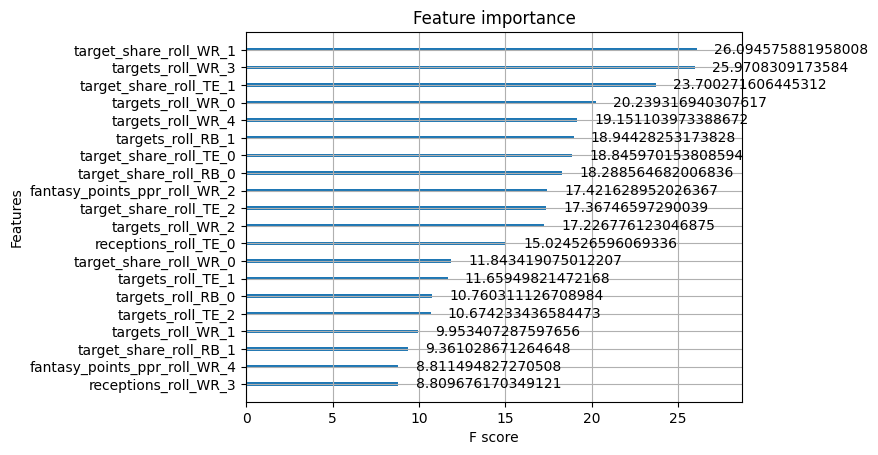

In [23]:
xgb.plot_importance(choose_receiver_model, importance_type="gain", max_num_features=20)

In [24]:
feature_config = {}
feature_config["receiver_idx_to_pos"] =  receiver_idx_to_pos
feature_config['choose_receiver_cols'] = choose_receiver_cols


In [25]:
feature_config.keys()

dict_keys(['receiver_idx_to_pos', 'choose_receiver_cols'])

In [26]:
update_config(feature_config)

In [27]:
player_context = [
        "season",
    "team_name",
    "week",
    "game_type",
    "gsis_id",
    "position",
    "depth_position",
    "full_name",
    "season_type",
]

In [28]:
receiver_cols = [
    "dense_depth",
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll',
 'passing_first_downs_roll',
 'offense_pct_roll']

receiver_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet', columns=receiver_cols+player_context)
receiver_stats

,dense_depth,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_ppr_roll,yards_per_carry_roll,passing_first_downs_roll,offense_pct_roll,season,team_name,week,game_type,gsis_id,position,depth_position,full_name,season_type
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,PIT,1.0,REG,00-0000045,T,RT,Flozell Adams,None
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,PIT,1.0,REG,00-0000865,QB,QB,Charlie Batch,None
3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,BAL,1.0,REG,00-0001263,C,C,Matt Birk,None
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,NYJ,1.0,REG,00-0002110,QB,QB,Mark Brunell,None
5,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,CHI,1.0,REG,00-0003035,TE,HB,Desmond Clark,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231628,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,PIT,13.0,REG,00-0039109,T,LT,Broderick Jones,None
231629,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,CLE,13.0,REG,00-0039350,G,LG,Zak Zinter,None
231630,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,PIT,13.0,REG,00-0039358,G,RG,Mason McCormick,None
231631,4.0,0.315406,0.315406,3.469471,0.0,0.662353,NaN,0.0,0.167271,2024,CLE,13.0,REG,00-0039379,WR,WR,Jamari Thrash,None


In [29]:
qb_cols = [
    'dense_depth',
    "passing_yards_roll",
    "fantasy_points_ppr_roll",
    "sacks_roll",
    "passing_yards_after_catch_roll",
    "interceptions_roll",
    "passing_tds_roll",
    "offense_pct_roll",
    "passing_air_yards_roll",
    "receiving_air_yards_roll",
    "passing_first_downs_roll",
    "sack_yards_roll",
    "completion_pct_roll"
]
qb_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet', columns=qb_cols+player_context)
qb_stats.loc[qb_stats.full_name == 'Patrick Mahomes']

,dense_depth,passing_yards_roll,fantasy_points_ppr_roll,sacks_roll,passing_yards_after_catch_roll,interceptions_roll,passing_tds_roll,offense_pct_roll,passing_air_yards_roll,receiving_air_yards_roll,...,completion_pct_roll,season,team_name,week,game_type,gsis_id,position,depth_position,full_name,season_type
110859,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017,KC,1.0,REG,00-0033873,QB,QB,Patrick Mahomes,None
111693,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017,KC,2.0,REG,00-0033873,QB,QB,Patrick Mahomes,None
112514,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017,KC,3.0,REG,00-0033873,QB,QB,Patrick Mahomes,None
113334,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017,KC,4.0,REG,00-0033873,QB,QB,Patrick Mahomes,None
114158,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017,KC,5.0,REG,00-0033873,QB,QB,Patrick Mahomes,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227885,0.0,236.104611,15.244359,1.600491,129.223906,1.258548,1.109739,0.999994,214.371864,-0.032581,...,0.690190,2024,KC,8.0,REG,00-0033873,QB,QB,Patrick Mahomes,REG
228686,0.0,253.926137,18.262145,2.379480,133.371604,0.849966,1.723403,0.999996,234.379144,-0.022004,...,0.692163,2024,KC,9.0,REG,00-0033873,QB,QB,Patrick Mahomes,REG
229482,0.0,257.698979,17.724009,2.885860,150.441890,0.584369,1.497354,0.999997,227.698588,-0.015128,...,0.691523,2024,KC,10.0,REG,00-0033873,QB,QB,Patrick Mahomes,REG
230259,0.0,238.921861,17.150641,2.616262,136.612363,1.015194,1.954661,0.999998,227.790318,-0.010524,...,0.692357,2024,KC,11.0,REG,00-0033873,QB,QB,Patrick Mahomes,REG


In [30]:
qb_stats.columns = [x + '_qb'  if x in qb_cols else x for x in qb_stats.columns]
qb_cols = [x + '_qb' for x in qb_cols]

In [31]:
passes = pbp.loc[(~pbp.receiver_player_id.isna()) & (pbp.play_type_enc == 2)].copy(
    deep=True
)
passes = passes.merge(
    qb_stats,
    left_on=["posteam", "season", "week", "passer_player_id"],
    right_on=["team_name", "season", "week", 'gsis_id'],
)
passes = passes.merge(
    receiver_stats,
    left_on=["posteam", "season", "week", "receiver_player_id"],
    right_on=["team_name", "season", "week", 'gsis_id'],
    suffixes=('_qb','')
)
passes

,play_id,game_id,old_game_id,home_team,away_team,season_type_x,week,posteam,posteam_type,defteam,...,yards_per_carry_roll,passing_first_downs_roll,offense_pct_roll,team_name,game_type,gsis_id,position,depth_position,full_name,season_type
0,58.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,NaN,0.000000e+00,NaN,ARI,REG,00-0023108,TE,TE,Stephen Spach,REG
1,103.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,NaN,0.000000e+00,NaN,ARI,REG,00-0022921,WR,WR,Larry Fitzgerald,REG
2,132.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,4.153846,0.000000e+00,NaN,ARI,REG,00-0026289,RB,RB,Tim Hightower,REG
3,177.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,NaN,0.000000e+00,NaN,ARI,REG,00-0025529,WR,WR,Steve Breaston,REG
4,254.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,LA,home,ARI,...,NaN,0.000000e+00,NaN,LA,REG,00-0023457,WR,WR,Mark Clayton,REG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271973,3812.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,NaN,0.000000e+00,0.751814,HOU,REG,00-0034383,TE,TE,Dalton Schultz,None
271974,3869.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,4.560776,4.043364e-09,0.707931,HOU,REG,00-0033897,RB,RB,Joe Mixon,None
271975,3894.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,4.560776,4.043364e-09,0.707931,HOU,REG,00-0033897,RB,RB,Joe Mixon,None
271976,3953.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,NaN,0.000000e+00,0.436993,HOU,REG,00-0039359,TE,TE,Cade Stover,None


In [32]:
completion_features = game_context_cols + qb_cols + receiver_cols + ['air_yards']
completion_features

['yardline_100',
 'down',
 'goal_to_go',
 'ydstogo',
 'posteam_score',
 'score_differential',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'wind',
 'temp',
 'spread_line',
 'total_line',
 'dense_depth_qb',
 'passing_yards_roll_qb',
 'fantasy_points_ppr_roll_qb',
 'sacks_roll_qb',
 'passing_yards_after_catch_roll_qb',
 'interceptions_roll_qb',
 'passing_tds_roll_qb',
 'offense_pct_roll_qb',
 'passing_air_yards_roll_qb',
 'receiving_air_yards_roll_qb',
 'passing_first_downs_roll_qb',
 'sack_yards_roll_qb',
 'completion_pct_roll_qb',
 'dense_depth',
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll',
 'passing_first_downs_roll',
 'offense_pct_roll',
 'air_yards']

In [33]:
passes[completion_features]

,yardline_100,down,goal_to_go,ydstogo,posteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,...,dense_depth,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_ppr_roll,yards_per_carry_roll,passing_first_downs_roll,offense_pct_roll,air_yards
0,78.0,1.0,0,10.0,0.0,0.0,895.0,1795.0,3595.0,NaN,...,1.0,1.000000,1.000000,0.000000,0.000000,1.000000,NaN,0.000000e+00,NaN,0.0
1,73.0,3.0,0,5.0,0.0,0.0,823.0,1723.0,3523.0,NaN,...,0.0,3.000000,15.000000,43.000000,1.000000,13.300000,NaN,0.000000e+00,NaN,7.0
2,55.0,1.0,0,10.0,0.0,0.0,797.0,1697.0,3497.0,NaN,...,0.0,4.000000,4.000000,40.000000,0.000000,15.400000,4.153846,0.000000e+00,NaN,0.0
3,36.0,2.0,0,8.0,0.0,0.0,727.0,1627.0,3427.0,NaN,...,1.0,7.000000,7.000000,132.000000,0.000000,20.200001,NaN,0.000000e+00,NaN,12.0
4,32.0,1.0,0,10.0,0.0,0.0,650.0,1550.0,3350.0,NaN,...,3.0,10.000000,16.000000,119.000000,0.000000,21.900000,NaN,0.000000e+00,NaN,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271973,49.0,1.0,0,10.0,27.0,-3.0,322.0,322.0,322.0,NaN,...,0.0,3.595031,5.547692,38.746028,0.006583,7.508952,NaN,0.000000e+00,0.751814,16.0
271974,38.0,1.0,0,15.0,27.0,-3.0,276.0,276.0,276.0,NaN,...,0.0,1.947200,3.440166,30.823058,0.068518,24.796145,4.560776,4.043364e-09,0.707931,-3.0
271975,31.0,2.0,0,8.0,27.0,-3.0,231.0,231.0,231.0,NaN,...,0.0,1.947200,3.440166,30.823058,0.068518,24.796145,4.560776,4.043364e-09,0.707931,0.0
271976,21.0,1.0,0,20.0,27.0,-3.0,177.0,177.0,177.0,NaN,...,1.0,1.204704,1.874108,9.224007,0.000000,2.127105,NaN,0.000000e+00,0.436993,-4.0


In [34]:
def create_model(df, x_cols, y_col, colsample_bytree=0.5):
    data = df.loc[~(df[y_col].isna())].copy(deep=True)
    X, y = data[x_cols], data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = xgb.XGBClassifier(eval_metric="mlogloss", colsample_bytree=colsample_bytree)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    display(cm)
    return model

In [35]:
completion_df = passes.loc[~passes.offense_pct_roll.isna()].copy()[completion_features + ['complete_pass']]#.dropna()
#231174

In [36]:
complete_pass_model = create_model(
    completion_df, x_cols=completion_features, y_col="complete_pass", colsample_bytree=0.6
)
joblib.dump(complete_pass_model, "models/complete_pass.joblib")

Accuracy: 0.75
Confusion Matrix:


array([[ 7557,  8709],
       [ 3031, 27070]], dtype=int64)

['models/complete_pass.joblib']

In [37]:
feature_config = {
    "complete_pass_cols": completion_features,
}
feature_config

update_config(feature_config)

In [38]:
passes.loc[passes.air_yards > 40]['complete_pass'].value_counts(normalize=True)

complete_pass
0.0    0.719433
1.0    0.280567
Name: proportion, dtype: float64